In [401]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import geopandas as gpd
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn import (linear_model,metrics,neural_network,pipeline,preprocessing,model_selection)
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from xgboost import plot_tree
import graphviz
from sklearn.feature_selection import SelectFromModel
from xgboost.callback import early_stop

from lightgbm import LGBMClassifier
import eli5
import warnings
warnings.filterwarnings("ignore")


In [216]:
url = "https://raw.githubusercontent.com/uplotnik/Data607/master/Suicide.csv"
data = pd.read_csv(url)

In [217]:
data.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,nan,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,nan,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,nan,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,nan,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,nan,"2,156,624,900",796,Boomers


In [218]:
data.columns

Index(['country', 'year', 'sex', 'age', 'suicides_no', 'population',
       'suicides/100k pop', 'country-year', 'HDI for year',
       ' gdp_for_year ($) ', 'gdp_per_capita ($)', 'generation'],
      dtype='object')

In [219]:
data.rename(columns = {' gdp_for_year ($) ':'gdp_for_year','gdp_per_capita ($)':'gdp_per_capita','suicides/100k pop':'suicides_per_100k_pop'},inplace=True)


In [220]:
data

,country,year,sex,age,suicides_no,population,suicides_per_100k_pop,country-year,HDI for year,gdp_for_year,gdp_per_capita,generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,nan,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,nan,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,nan,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,nan,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,nan,"2,156,624,900",796,Boomers
5,Albania,1987,female,75+ years,1,35600,2.81,Albania1987,nan,"2,156,624,900",796,G.I. Generation
6,Albania,1987,female,35-54 years,6,278800,2.15,Albania1987,nan,"2,156,624,900",796,Silent
7,Albania,1987,female,25-34 years,4,257200,1.56,Albania1987,nan,"2,156,624,900",796,Boomers
8,Albania,1987,male,55-74 years,1,137500,0.73,Albania1987,nan,"2,156,624,900",796,G.I. Generation
...,...,...,...,...,...,...,...,...,...,...,...,...


# Data Wrangling 

In [221]:
mean =  data["suicides_per_100k_pop"].mean()


In [222]:
# Creating a binary class 

# If suicides_per_100k_pop > mean(suicides_per_100k_pop), then high risk
# Else, low risk
data['risk'] = (data['suicides_per_100k_pop']>=mean)*1
#If we don't mulltiply by 1, we will get the output in the form of True and False

In [223]:
data

,country,year,sex,age,suicides_no,population,suicides_per_100k_pop,country-year,HDI for year,gdp_for_year,gdp_per_capita,generation,risk
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,nan,"2,156,624,900",796,Generation X,0
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,nan,"2,156,624,900",796,Silent,0
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,nan,"2,156,624,900",796,Generation X,0
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,nan,"2,156,624,900",796,G.I. Generation,0
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,nan,"2,156,624,900",796,Boomers,0
5,Albania,1987,female,75+ years,1,35600,2.81,Albania1987,nan,"2,156,624,900",796,G.I. Generation,0
6,Albania,1987,female,35-54 years,6,278800,2.15,Albania1987,nan,"2,156,624,900",796,Silent,0
7,Albania,1987,female,25-34 years,4,257200,1.56,Albania1987,nan,"2,156,624,900",796,Boomers,0
8,Albania,1987,male,55-74 years,1,137500,0.73,Albania1987,nan,"2,156,624,900",796,G.I. Generation,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [224]:
data.isnull().sum()

country                      0
year                         0
sex                          0
age                          0
suicides_no                  0
population                   0
suicides_per_100k_pop        0
country-year                 0
HDI for year             19456
gdp_for_year                 0
gdp_per_capita               0
generation                   0
risk                         0
dtype: int64

In [225]:
#cleaning the data

# Dropping HDI_for_year because of a lot of missing values
data.drop(columns = 'HDI for year',axis = 1,inplace=True)

# Removing commas from the "gdp_for_year" column
data['gdp_for_year'] = data['gdp_for_year'].str.replace(",","")


In [226]:
data.head()

,country,year,sex,age,suicides_no,population,suicides_per_100k_pop,country-year,gdp_for_year,gdp_per_capita,generation,risk
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,2156624900,796,Generation X,0
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,2156624900,796,Silent,0
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,2156624900,796,Generation X,0
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,2156624900,796,G.I. Generation,0
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,2156624900,796,Boomers,0


In [227]:
data.isnull().any()
# Checking if there is any missing values again


country                  False
year                     False
sex                      False
age                      False
suicides_no              False
population               False
suicides_per_100k_pop    False
country-year             False
gdp_for_year             False
gdp_per_capita           False
generation               False
risk                     False
dtype: bool

In [228]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   country                27820 non-null  object 
 1   year                   27820 non-null  int64  
 2   sex                    27820 non-null  object 
 3   age                    27820 non-null  object 
 4   suicides_no            27820 non-null  int64  
 5   population             27820 non-null  int64  
 6   suicides_per_100k_pop  27820 non-null  float64
 7   country-year           27820 non-null  object 
 8   gdp_for_year           27820 non-null  object 
 9   gdp_per_capita         27820 non-null  int64  
 10  generation             27820 non-null  object 
 11  risk                   27820 non-null  int32  
dtypes: float64(1), int32(1), int64(4), object(6)
memory usage: 2.4+ MB


In [229]:
data['gdp_for_year'] =data['gdp_for_year'].astype(float)

In [230]:
data['gdp_for_year'].dtype

dtype('float64')

In [231]:
# Summary of statistics for numerical variables

# 2 decimal places
pd.options.display.float_format = "{:.2f}".format
data.describe()

,year,suicides_no,population,suicides_per_100k_pop,gdp_for_year,gdp_per_capita,risk
count,27820.00,27820.00,27820.00,27820.00,27820.00,27820.00,27820.00
mean,2001.26,242.57,1844793.62,12.82,445580969025.73,16866.46,0.31
std,8.47,902.05,3911779.44,18.96,1453609985940.91,18887.58,0.46
min,1985.00,0.00,278.00,0.00,46919625.00,251.00,0.00
25%,1995.00,3.00,97498.50,0.92,8985352832.00,3447.00,0.00
50%,2002.00,25.00,430150.00,5.99,48114688201.00,9372.00,0.00
75%,2008.00,131.00,1486143.25,16.62,260202429150.00,24874.00,1.00
max,2016.00,22338.00,43805214.00,224.97,18120714000000.00,126352.00,1.00


In [232]:
# Number of unique values 
data.nunique()

country                    101
year                        32
sex                          2
age                          6
suicides_no               2084
population               25564
suicides_per_100k_pop     5298
country-year              2321
gdp_for_year              2321
gdp_per_capita            2233
generation                   6
risk                         2
dtype: int64

In [233]:
# Unique values for relevant columns
cols = data[["country", "year", "sex", "age", "generation", "risk"]]

for column in list(cols):
    print(f"\033[1m  {column} unique values: \033[0m") #makes the heading bold
    print("")
    print(data[column].unique())
    print("")

  country unique values: 

['Albania' 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Aruba' 'Australia'
 'Austria' 'Azerbaijan' 'Bahamas' 'Bahrain' 'Barbados' 'Belarus' 'Belgium'
 'Belize' 'Bosnia and Herzegovina' 'Brazil' 'Bulgaria' 'Cabo Verde'
 'Canada' 'Chile' 'Colombia' 'Costa Rica' 'Croatia' 'Cuba' 'Cyprus'
 'Czech Republic' 'Denmark' 'Dominica' 'Ecuador' 'El Salvador' 'Estonia'
 'Fiji' 'Finland' 'France' 'Georgia' 'Germany' 'Greece' 'Grenada'
 'Guatemala' 'Guyana' 'Hungary' 'Iceland' 'Ireland' 'Israel' 'Italy'
 'Jamaica' 'Japan' 'Kazakhstan' 'Kiribati' 'Kuwait' 'Kyrgyzstan' 'Latvia'
 'Lithuania' 'Luxembourg' 'Macau' 'Maldives' 'Malta' 'Mauritius' 'Mexico'
 'Mongolia' 'Montenegro' 'Netherlands' 'New Zealand' 'Nicaragua' 'Norway'
 'Oman' 'Panama' 'Paraguay' 'Philippines' 'Poland' 'Portugal'
 'Puerto Rico' 'Qatar' 'Republic of Korea' 'Romania' 'Russian Federation'
 'Saint Kitts and Nevis' 'Saint Lucia' 'Saint Vincent and Grenadines'
 'San Marino' 'Serbia' 'Seychelles' 'Singapore' 'Sl

In [234]:
# correlation matrix
continuous = data.drop(columns = ['risk'],axis = 1)
corr  = continuous.corr()
corr

,year,suicides_no,population,suicides_per_100k_pop,gdp_for_year,gdp_per_capita
year,1.00,-0.00,0.01,-0.04,0.09,0.34
suicides_no,-0.00,1.00,0.62,0.31,0.43,0.06
population,0.01,0.62,1.00,0.01,0.71,0.08
suicides_per_100k_pop,-0.04,0.31,0.01,1.00,0.03,0.00
gdp_for_year,0.09,0.43,0.71,0.03,1.00,0.30
gdp_per_capita,0.34,0.06,0.08,0.00,0.30,1.00


In [235]:
corr_lower = corr.where(np.tril(np.ones(corr.shape)).astype(bool))
#Return a copy of an array with elements above the `k`-th diagonal zeroed(np.tril)
corr_lower

,year,suicides_no,population,suicides_per_100k_pop,gdp_for_year,gdp_per_capita
year,1.00,nan,nan,nan,nan,nan
suicides_no,-0.00,1.00,nan,nan,nan,nan
population,0.01,0.62,1.00,nan,nan,nan
suicides_per_100k_pop,-0.04,0.31,0.01,1.00,nan,nan
gdp_for_year,0.09,0.43,0.71,0.03,1.00,nan
gdp_per_capita,0.34,0.06,0.08,0.00,0.30,1.00


Text(0.06, -0.16, 'Fig. 1. Correlation heatmap')

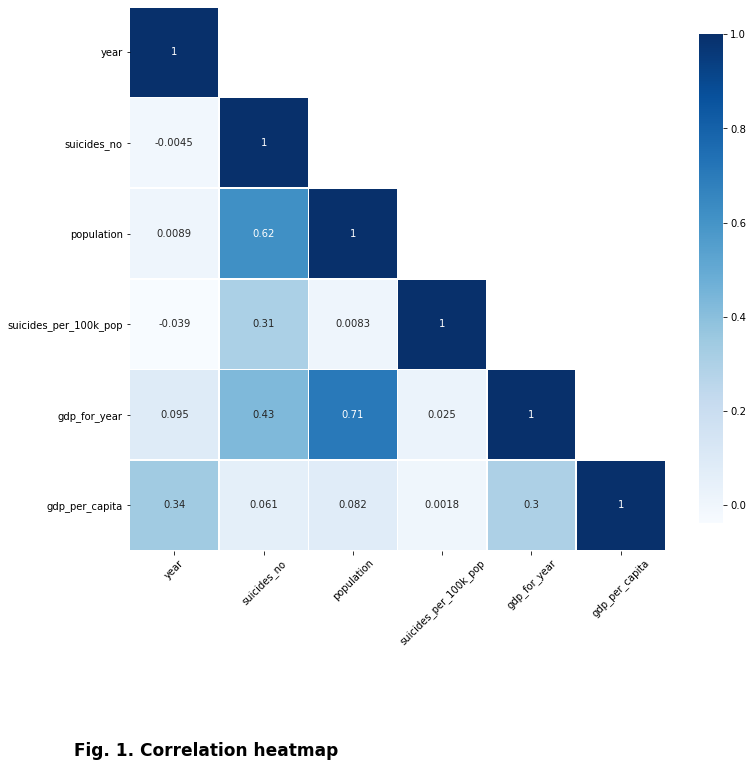

In [236]:
fig,ax = plt.subplots(figsize = (12,10))

ax = sns.heatmap(corr_lower,cmap='Blues',annot = True,linewidths=0.5,cbar_kws={'shrink':0.9})
ax.tick_params(axis = "both",labelsize = 10)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
fig.text(0.06,-0.16,"Fig. 1. Correlation heatmap", fontsize = 17, fontweight = "bold")

# Visualization of the features

# total suicide by year

In [237]:
data.head()

,country,year,sex,age,suicides_no,population,suicides_per_100k_pop,country-year,gdp_for_year,gdp_per_capita,generation,risk
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,2156624900.00,796,Generation X,0
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,2156624900.00,796,Silent,0
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,2156624900.00,796,Generation X,0
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,2156624900.00,796,G.I. Generation,0
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,2156624900.00,796,Boomers,0


In [238]:
yearly_data = data.groupby("year").sum()
yearly_data

,suicides_no,population,suicides_per_100k_pop,gdp_for_year,gdp_per_capita,risk
year,,,,,,
1985,116063,1008600086,6811.89,110964754234500.00,3508548,160
1986,120670,1029909613,6579.84,132609631982868.00,4104636,157
1987,126842,1095029726,7545.45,155769882274200.00,5645760,187
1988,121026,1054094424,7473.13,175557691204476.00,5870508,196
1989,160244,1225514347,8036.54,191618261647176.00,6068424,205
1990,193361,1466620100,9878.75,236464399957008.00,7531260,253
1991,198020,1489988384,10321.06,252102888610440.00,7782096,259
1992,211473,1569539447,10528.88,268107812488032.00,8195232,265
1993,221565,1530416654,10790.29,271037019424788.00,8231796,259


In [239]:
yearly_data.reset_index(level = 0,inplace=True)

In [240]:
yearly_data

,year,suicides_no,population,suicides_per_100k_pop,gdp_for_year,gdp_per_capita,risk
0,1985,116063,1008600086,6811.89,110964754234500.00,3508548,160
1,1986,120670,1029909613,6579.84,132609631982868.00,4104636,157
2,1987,126842,1095029726,7545.45,155769882274200.00,5645760,187
3,1988,121026,1054094424,7473.13,175557691204476.00,5870508,196
4,1989,160244,1225514347,8036.54,191618261647176.00,6068424,205
5,1990,193361,1466620100,9878.75,236464399957008.00,7531260,253
6,1991,198020,1489988384,10321.06,252102888610440.00,7782096,259
7,1992,211473,1569539447,10528.88,268107812488032.00,8195232,265
8,1993,221565,1530416654,10790.29,271037019424788.00,8231796,259
...,...,...,...,...,...,...,...


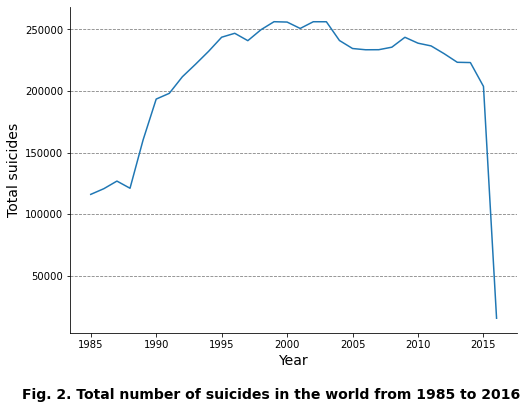

In [241]:
yearly_suicide_graph = yearly_data.plot(x = "year", y = "suicides_no",kind = "line",figsize  = (8,6))
yearly_suicide_graph.spines["top"].set_visible(False) # removes the top boundaries of the plot
yearly_suicide_graph.spines["right"].set_visible(False) # removes the right boundaries of the plot
yearly_suicide_graph.get_legend().remove() # removes legend
yearly_suicide_graph.set_xlabel("Year",size = 14)
yearly_suicide_graph.set_ylabel("Total suicides",size = 14)
yearly_suicide_graph.set_title("Fig. 2. Total number of suicides in the world from 1985 to 2016"
                               ,size = 14,x = 0.45, y = -0.22,  fontweight = "bold") # without x and y the title will be on top

yearly_suicide_graph.yaxis.grid(color = "gray", linestyle = "dashed")
yearly_suicide_graph.set_axisbelow(True) #the line is on top of the dashlines, if it's false, the dashlines are on top

# total suicides by gender

In [242]:
print("Number of males and females") # to check whether the males and female class are balanced
count1 = data['sex'].value_counts()
count1

Number of males and females


female    13910
male      13910
Name: sex, dtype: int64

In [243]:
gender_data = data.groupby(["year","sex"]).sum()
gender_data

suicides_no  population  ...  gdp_per_capita  risk
year sex                              ...                      
1985 female        32479   513013055  ...         1754274    35
     male          83584   495587031  ...         1754274   125
1986 female        33852   524465866  ...         2052318    33
     male          86818   505443747  ...         2052318   124
1987 female        35006   559183789  ...         2822880    39
     male          91836   535845937  ...         2822880   148
1988 female        33015   538779773  ...         2935254    41
     male          88011   515314651  ...         2935254   155
1989 female        41361   629626203  ...         3034212    38
...                  ...         ...  ...             ...   ...
2012 male         177149   934418340  ...        13029150   244
2013 female        51459   965830178  ...        13455684    35
     male         171740   924331532  ...        13455684   237
2014 female        51556   977579014  ...        12832626    31
     male         171428   934478295  ...        12832626   225
2015 female        47248   907777656  ...         9758004    28
     male         156392   866880276  ...         9758004   188
2016 female         3504    67368499  ...         2053210     3
     male          12099    64733397  ...         2053210    52

[64 rows x 6 columns]

In [244]:
gender_table = gender_data.pivot_table(index = "year",columns="sex",values = "suicides_no", aggfunc="sum")
gender_table


sex,female,male
year,,
1985,32479,83584
1986,33852,86818
1987,35006,91836
1988,33015,88011
1989,41361,118883
1990,50118,143243
1991,49622,148398
1992,51567,159906
1993,51331,170234


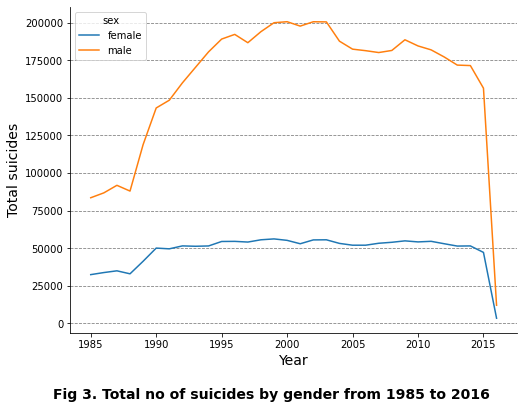

In [245]:
gender_graph = gender_table.plot(figsize = (8,6))
gender_graph.spines["right"].set_visible(False)
gender_graph.spines["top"].set_visible(False)
gender_graph.set_xlabel("Year",size = 14)
gender_graph.set_ylabel("Total suicides",size = 14)
gender_graph.set_title("Fig 3. Total no of suicides by gender from 1985 to 2016", x= 0.45,y = -0.22,size = 14,fontweight = "bold")
gender_graph.set_axisbelow(True)
gender_graph.yaxis.grid(color = "gray", linestyle = "dashed")


# total suicides by age

In [246]:
print("\033[1m Number of observations for each band: \033[0m")
count  = data['age'].value_counts()
count

 Number of observations for each band: 


35-54 years    4642
15-24 years    4642
25-34 years    4642
55-74 years    4642
75+ years      4642
5-14 years     4610
Name: age, dtype: int64

In [247]:
age_table = data.pivot_table(index = "age",values ="suicides_no" ,aggfunc="sum" )
age_table.reset_index(level=0,inplace = True)
age_table

,age,suicides_no
0,15-24 years,808542
1,25-34 years,1123912
2,35-54 years,2452141
3,5-14 years,52264
4,55-74 years,1658443
5,75+ years,653118


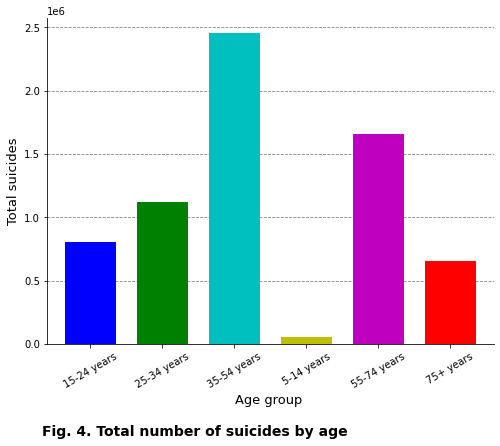

In [248]:
colors = ["b","g","c","y","m","r"]
age_graph = age_table.plot(x = "age", y = "suicides_no",color = colors,kind = "bar",width = 0.7, figsize = (8,6))
plt.xlabel("Age group ", size = 13)
plt.ylabel("Total suicides", size = 13)
plt.title("Fig. 4. Total number of suicides by age", x = 0.33, y = -0.3,size = 14, fontweight = "bold")
plt.xticks(rotation = 30)
age_graph.spines["right"].set_visible(False)
age_graph.spines["top"].set_visible(False)
age_graph.get_legend().remove()

age_graph.set_axisbelow(True)
age_graph.yaxis.grid(linestyle = "dashed",color = "gray")

# Total Suicides and Year by Gender and Age

In [249]:
gender_age_data = data.groupby(["year","age","sex"]).suicides_no.sum().reset_index()
gender_age_data

,year,age,sex,suicides_no
0,1985,15-24 years,female,4690
1,1985,15-24 years,male,13180
2,1985,25-34 years,female,4894
3,1985,25-34 years,male,15877
4,1985,35-54 years,female,9476
5,1985,35-54 years,male,26272
6,1985,5-14 years,female,351
7,1985,5-14 years,male,633
8,1985,55-74 years,female,9057
...,...,...,...,...


In [174]:
#def plot(df, sex, age, ax, color):
    
    #df.plot(
        kind = "line", x = "year", y = "suicides_no", ax = ax, color = color
)
    return ax
#fig, ax = plt.subplots(1, 2, figsize=(11, 6), sharey=True)

# Naming the legends
#labels = ["15-24 years", "35-54 years", "75+ years", "25-34 years", "55-74 years", "5-14 years"]

#for (i, sex) in enumerate(gender_age_data.sex.unique()):
    plot(gender_age_data, sex,"15-24 years", ax[i], "b")
    plot(gender_age_data, sex,"35-54 years", ax[i], "r")
    plot(gender_age_data, sex,"75+ years", ax[i], "k")
    plot(gender_age_data, sex,"25-34 years", ax[i], "y")
    plot(gender_age_data, sex,"55-74 years", ax[i], "g")
    plot(gender_age_data, sex,"5-14 years", ax[i], "m")
    ax[i].set_title(str(sex))
    ax[i].legend(labels = labels)
    

#for (i, _ax) in enumerate(ax):
    
    # setting axis labels
    _ax.set_xlabel("Year", size = 13)
    _ax.set_ylabel("Total Suicides", size = 13)
    
    _ax.spines['right'].set_visible(False)
    _ax.spines['top'].set_visible(False)
    
    _ax.yaxis.grid(True)
    

#plt.suptitle("Fig. 5. Total number of suicides by age and sex from 1985 to 2016", x = 0.43, 
             y = -0.05, fontsize=15, fontweight = "bold")
#plt.show()
#the issue with the graph is that both look alike and all the suicides_no has been ploted against the respective year
# what we need is two different graphs for male and female and suicidal_nos projections in each age categories for the respective years
#df.query()solves that problem by selecting only 

IndentationError: unexpected indent (<ipython-input-174-19d3293c446b>, line 4)

In [175]:
#gender_age_data.query("(age==@age) & (sex==@sex)" ) 
# we can't use this as a standalone as @(variable) refers to a local variable which must be defined inside a function

Text(0.43, -0.05, 'Fig. 5. Total number of suicides by age and sex from 1985 to 2016')

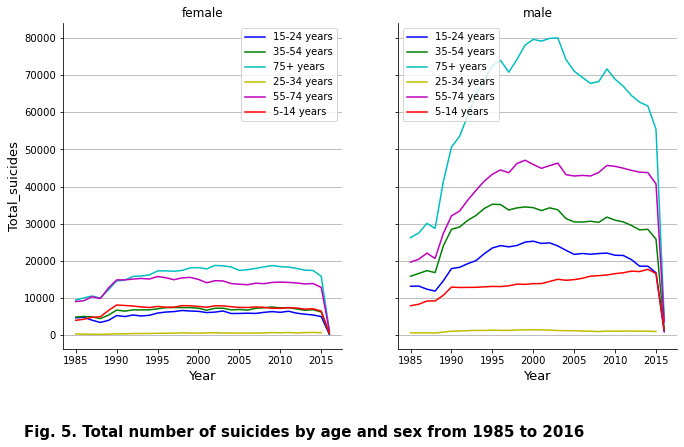

In [250]:
def plot(df,sex,age,ax,color):
    df.query("(age==@age) & (sex==@sex)").plot(kind= "line", x = "year", y= "suicides_no", ax= ax,color = color)
    
    return ax
fig,ax = plt.subplots(1,2,figsize = (11,6),sharey = True)
labels = ["15-24 years", "35-54 years", "75+ years", "25-34 years", "55-74 years", "5-14 years"]

for (i,sex) in enumerate(gender_age_data.sex.unique()):
    plot(gender_age_data,sex,'15-24 years',ax[i],"b")
    plot(gender_age_data,sex,'25-34 years',ax[i],"g")
    plot(gender_age_data,sex,'35-54 years',ax[i],"c")
    plot(gender_age_data,sex,'5-14 years',ax[i],"y")
    plot(gender_age_data,sex,'55-74 years',ax[i],"m")
    plot(gender_age_data,sex,'75+ years',ax[i],"r")
    ax[i].set_title(str(sex))
    ax[i].legend(labels = labels)
    
for(i,ax_) in enumerate(ax):
    
    ax_.set_xlabel("Year",size = 13)
    ax_.set_ylabel("Total_suicides", size = 13)
    ax_.spines['right'].set_visible(False)
    ax_.spines['top'].set_visible(False)
    ax_.yaxis.grid(True)
    
plt.suptitle("Fig. 5. Total number of suicides by age and sex from 1985 to 2016", x = 0.43, 
             y = -0.05, fontsize=15, fontweight = "bold")
    
    

In [251]:
list(enumerate(gender_age_data.sex.unique()))

[(0, 'female'), (1, 'male')]

In [252]:
list(enumerate(ax))

[(0,
  <AxesSubplot:title={'center':'female'}, xlabel='Year', ylabel='Total_suicides'>),
 (1,
  <AxesSubplot:title={'center':'male'}, xlabel='Year', ylabel='Total_suicides'>)]

# suicides rate for different country and year

In [253]:
country_year_data = data.groupby(["country","year"]).sum()

country_year_data_suicides = country_year_data[["suicides_per_100k_pop"]]
country_year_data_suicides

suicides_per_100k_pop
country    year                       
Albania    1987                  31.85
           1988                  32.46
           1989                  33.40
           1992                  18.00
           1993                  32.56
           1994                  32.18
           1995                  40.55
           1996                  43.62
           1997                  77.43
...                                ...
Uzbekistan 2003                  82.06
           2004                  68.04
           2005                  67.81
           2009                  60.86
           2010                  63.23
           2011                  67.14
           2012                  77.53
           2013                  78.86
           2014                  85.12

[2321 rows x 1 columns]

In [254]:
#we want the country to be a column and not an index. there are two indices(country,year{0,1} resp)
#if we want the year to be a column , dn levels =1, if country to be a column, dn level = 0
#if we want both the indices to be columns, dn we won't pass any levels

In [255]:
country_year_data_suicides.reset_index(inplace = True)
                                

In [256]:
country_year_data_suicides.columns = ["country","year","Suicides per 100k Population"]

In [257]:
country_year_data_suicides

,country,year,Suicides per 100k Population
0,Albania,1987,31.85
1,Albania,1988,32.46
2,Albania,1989,33.40
3,Albania,1992,18.00
4,Albania,1993,32.56
5,Albania,1994,32.18
6,Albania,1995,40.55
7,Albania,1996,43.62
8,Albania,1997,77.43
...,...,...,...


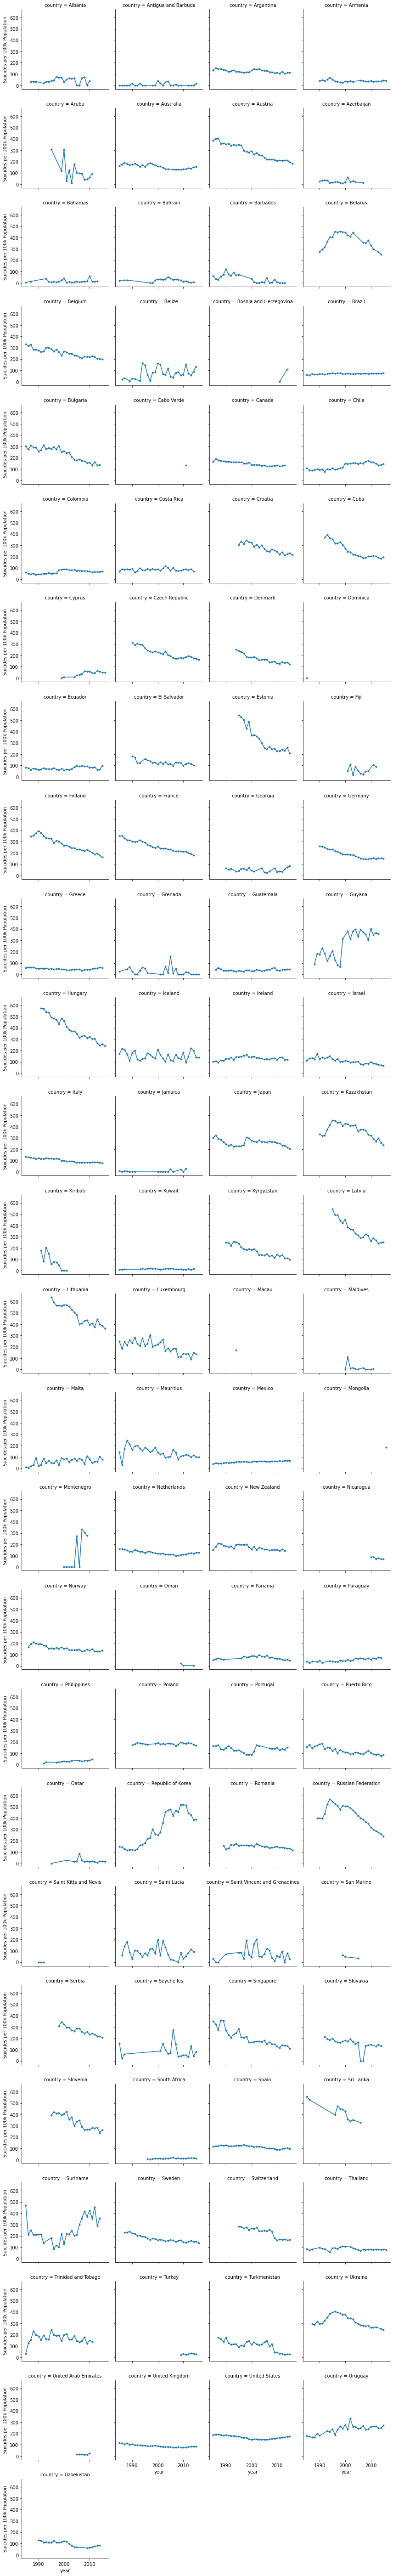

In [258]:
country_year_graph = sns.FacetGrid(country_year_data_suicides,col = "country",col_wrap = 4,sharey = True) #col_wrap= hw many columns u want
country_year_graph.map(plt.plot,"year","Suicides per 100k Population",marker = ".")

# World map of suicide rates

In [259]:
country_data = data.groupby("country").sum()
country_data_suicides = country_data[["suicides_per_100k_pop"]].reset_index()
country_data_suicides = country_data_suicides.sort_values("suicides_per_100k_pop",ascending = False)
country_data_suicides.head()

,country,suicides_per_100k_pop
75,Russian Federation,11305.13
52,Lithuania,10588.88
40,Hungary,10156.07
47,Kazakhstan,9519.52
73,Republic of Korea,9350.45


In [260]:
# finding the list of countries that are not in the world dataset

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")
world

,pop_est,continent,name,gdp_md_est,geometry
iso_a3,,,,,
FJI,920938,Oceania,Fiji,8374.00,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
TZA,53950935,Africa,Tanzania,150600.00,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
ESH,603253,Africa,W. Sahara,906.50,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
CAN,35623680,North America,Canada,1674000.00,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
USA,326625791,North America,United States of America,18560000.00,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
KAZ,18556698,Asia,Kazakhstan,460700.00,"POLYGON ((87.35997 49.21498, 86.59878 48.54918..."
UZB,29748859,Asia,Uzbekistan,202300.00,"POLYGON ((55.96819 41.30864, 55.92892 44.99586..."
PNG,6909701,Oceania,Papua New Guinea,28020.00,"MULTIPOLYGON (((141.00021 -2.60015, 142.73525 ..."
IDN,260580739,Asia,Indonesia,3028000.00,"MULTIPOLYGON (((141.00021 -2.60015, 141.01706 ..."


In [213]:
data_country = list(data.country.unique())
world_country = list(world.name.unique())


In [214]:
np.sort(list(set(data_country)-set(world_country)))

array(['Antigua and Barbuda', 'Aruba', 'Bahrain', 'Barbados',
       'Bosnia and Herzegovina', 'Cabo Verde', 'Czech Republic',
       'Dominica', 'Grenada', 'Kiribati', 'Macau', 'Maldives', 'Malta',
       'Mauritius', 'Republic of Korea', 'Russian Federation',
       'Saint Kitts and Nevis', 'Saint Lucia',
       'Saint Vincent and Grenadines', 'San Marino', 'Seychelles',
       'Singapore', 'United States'], dtype='<U28')

In [261]:
country_data_suicides.loc[country_data_suicides.country == "Bosnia and Herzegovina", "country"] = "Bosnia and Herz."
country_data_suicides.loc[country_data_suicides.country == "Russian Federation", "country"] = "Russia"
country_data_suicides.loc[country_data_suicides.country == "United States", "country"] = "United States of America"
country_data_suicides.loc[country_data_suicides.country == "Dominica", "country"] = "Dominican Rep."
country_data_suicides.loc[country_data_suicides.country == "Czech Republic", "country"] = "Czechia"
country_data_suicides.loc[country_data_suicides.country == "Republic of Korea", "country"] = "South Korea"

In [262]:
country_data_suicides

,country,suicides_per_100k_pop
75,Russia,11305.13
52,Lithuania,10588.88
40,Hungary,10156.07
47,Kazakhstan,9519.52
73,South Korea,9350.45
6,Austria,9076.23
95,Ukraine,8931.66
46,Japan,8025.23
32,Finland,7924.11
...,...,...


In [263]:
world_data = world.merge(country_data_suicides,left_on = "name",right_on = "country",how ="inner" )
# only the common elements.since world and country _suicides have different col names and we want to merge them,
#hence left_on and right_on

In [264]:
world_data

,pop_est,continent,name,gdp_md_est,geometry,country,suicides_per_100k_pop
0,920938,Oceania,Fiji,8374.00,"MULTIPOLYGON (((180.000 -16.067, 180.000 -16.5...",Fiji,673.86
1,35623680,North America,Canada,1674000.00,"MULTIPOLYGON (((-122.840 49.000, -122.974 49.0...",Canada,4338.72
2,326625791,North America,United States of America,18560000.00,"MULTIPOLYGON (((-122.840 49.000, -120.000 49.0...",United States of America,5140.97
3,18556698,Asia,Kazakhstan,460700.00,"POLYGON ((87.360 49.215, 86.599 48.549, 85.768...",Kazakhstan,9519.52
4,29748859,Asia,Uzbekistan,202300.00,"POLYGON ((55.968 41.309, 55.929 44.996, 58.503...",Uzbekistan,2138.17
5,44293293,South America,Argentina,879400.00,"MULTIPOLYGON (((-68.634 -52.636, -68.250 -53.1...",Argentina,3894.59
6,17789267,South America,Chile,436100.00,"MULTIPOLYGON (((-68.634 -52.636, -68.633 -54.8...",Chile,3921.64
7,10734247,North America,Dominican Rep.,161900.00,"POLYGON ((-71.708 18.045, -71.688 18.317, -71....",Dominican Rep.,0.00
8,142257519,Europe,Russia,3745000.00,"MULTIPOLYGON (((178.725 71.099, 180.000 71.516...",Russia,11305.13
...,...,...,...,...,...,...,...


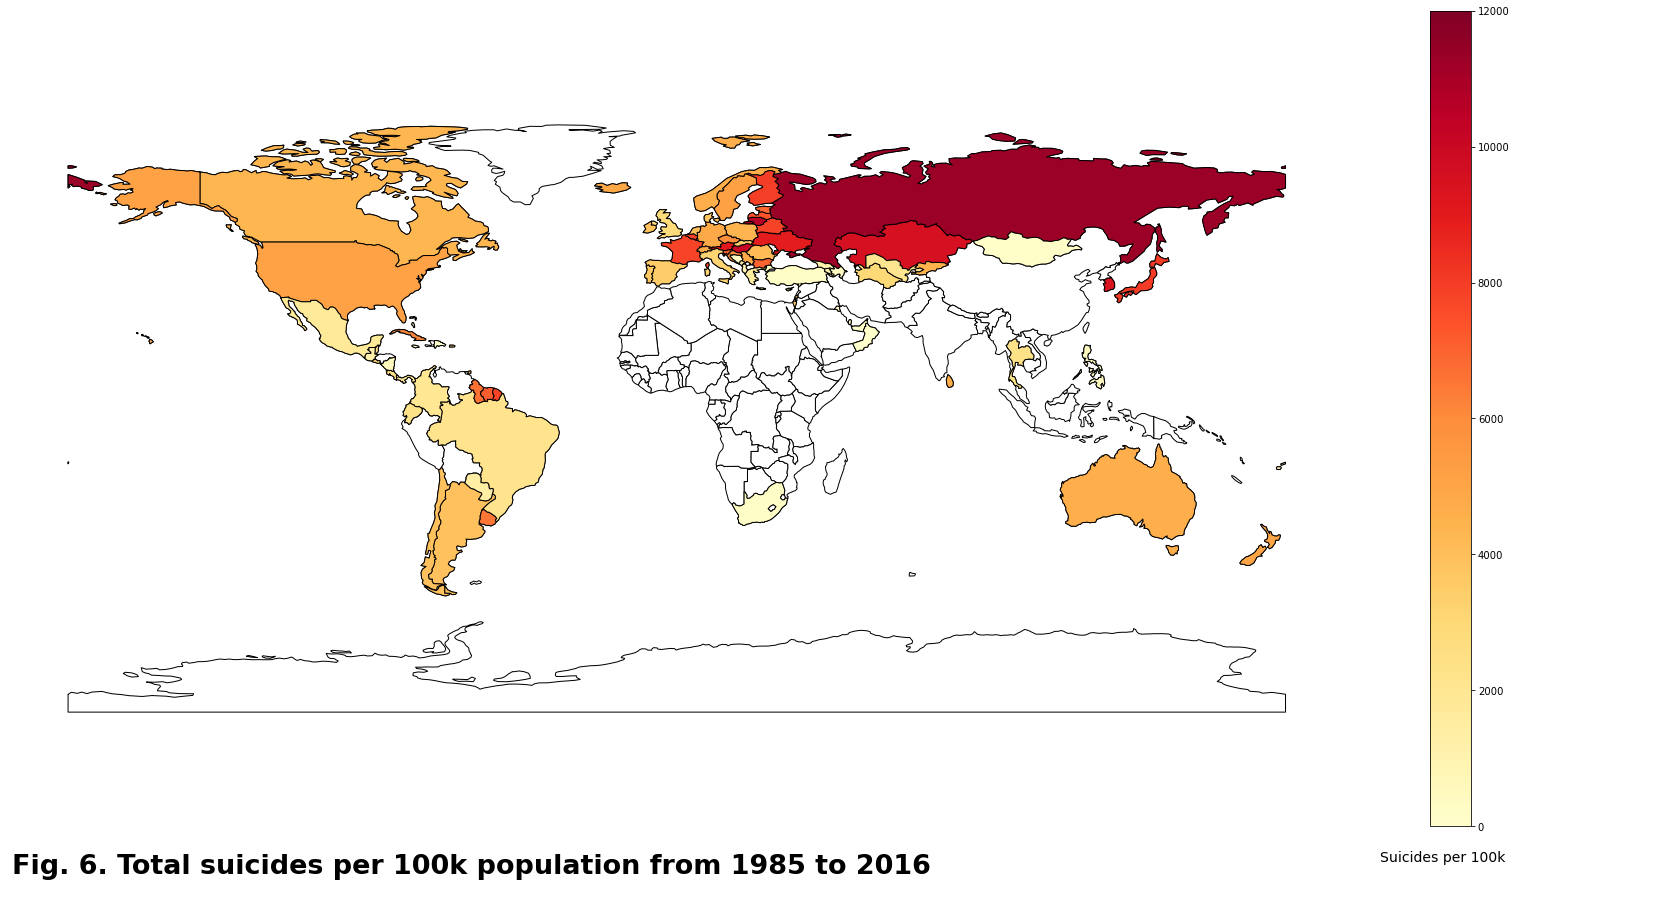

In [265]:
fig,ax = plt.subplots(figsize = (30,15))
world.plot(ax= ax,edgecolor = 'black',color = "white")
world_data.plot(ax=ax,legend = True,column = 'suicides_per_100k_pop',edgecolor = "black",vmin = 0,vmax = 12000,cmap ="YlOrRd")
plt.axis("off")

ax.annotate("Suicides per 100k",xy = (0.83,0.055), xycoords = 'figure fraction', size = 14)
plt.suptitle("Fig. 6. Total suicides per 100k population from 1985 to 2016", x = 0.34, y = 0.1, 
             fontsize=27, fontweight = "bold")
plt.show()

# GDP per Capita and Suicide Rates

In [278]:
avg_gdp_data = data.groupby("country").agg({"suicides_no":"sum","suicides_per_100k_pop":"sum","gdp_per_capita":"mean",
                                            "gdp_for_year":"mean"})
avg_gdp_data.reset_index()

,country,suicides_no,suicides_per_100k_pop,gdp_per_capita,gdp_for_year
0,Albania,1970,924.76,1859.05,5211661212.14
1,Antigua and Barbuda,11,179.14,10448.19,803545216.70
2,Argentina,82219,3894.59,7914.10,274256497624.61
3,Armenia,1905,976.21,1873.92,5386592177.83
4,Aruba,101,1596.52,24221.64,2196223463.79
5,Australia,70111,4677.41,32776.40,632750138055.83
6,Austria,50073,9076.23,34261.78,266016249973.92
7,Azerbaijan,1656,356.24,1005.12,7210687311.81
8,Bahamas,93,344.28,25836.39,7613828252.17
...,...,...,...,...,...


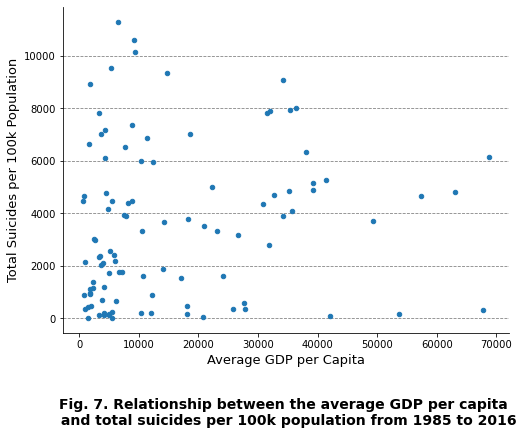

In [279]:
plt.rcParams["figure.figsize"] = [8, 6]

avg_gdp_graph = avg_gdp_data.plot(x = "gdp_per_capita",y = "suicides_per_100k_pop", kind = "scatter")

avg_gdp_graph.spines["right"].set_visible(False)
avg_gdp_graph.spines["top"].set_visible(False)

avg_gdp_graph.set_xlabel("Average GDP per Capita", size = 13)
avg_gdp_graph.set_ylabel("Total Suicides per 100k Population", size = 13)
avg_gdp_graph.set_title("Fig. 7. Relationship between the average GDP per capita \n and total suicides per 100k population from 1985 to 2016", 
                        size = 14,
                        x = 0.5, y = -0.3,
                        fontweight = "bold")

avg_gdp_graph.set_axisbelow(True)
avg_gdp_graph.yaxis.grid(color = "gray", linestyle = "dashed")

# Comparison of the Average GDP per Year and Total Suicide Rates

In [280]:
gdp_suicides_data = data.pivot_table(["suicides_per_100k_pop", "gdp_per_capita"], index = "year",aggfunc="mean")
gdp_suicides_data

,gdp_per_capita,suicides_per_100k_pop
year,,
1985,6091.23,11.83
1986,7126.10,11.42
1987,8712.59,11.64
1988,9983.86,12.71
1989,9725.04,12.88
1990,9806.33,12.86
1991,10132.94,13.44
1992,10506.71,13.50
1993,10553.58,13.83


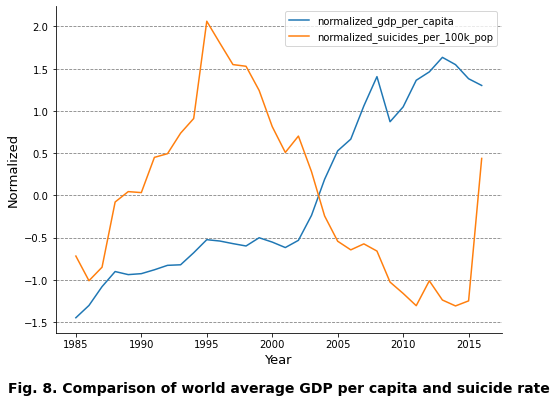

In [281]:
#standardization
normalized = (gdp_suicides_data-gdp_suicides_data.mean())/gdp_suicides_data.std()
normalized.columns = ["normalized_gdp_per_capita","normalized_suicides_per_100k_pop"]

plt.rcParams["figure.figsize"] = [8, 6]
ax = normalized.plot()

ax.set_xlabel("Year", size = 13)
ax.set_ylabel("Normalized", size = 13)
ax.set_title("Fig. 8. Comparison of world average GDP per capita and suicide rate", 
                        size = 14,
                        x = 0.5, y = -0.2,
                        fontweight = "bold")

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_axisbelow(True)
ax.yaxis.grid(color = "gray", linestyle = "dashed")

In [282]:
print("\033[1m no. of observations for each generation \033[0m")
count = data["generation"].value_counts()
count


 no. of observations for each generation 


Generation X       6408
Silent             6364
Millenials         5844
Boomers            4990
G.I. Generation    2744
Generation Z       1470
Name: generation, dtype: int64

In [283]:
#Therefore, the number of observations is not balanced across the generations,
#and generation Z and G.I generation have the lowest number of observations. 
#This could explain their low total suicide rates as graphed below.

In [284]:
gen_table = data.pivot_table('suicides_no',index = 'generation',aggfunc=sum)
gen_table.reset_index(inplace = True)
gen_table

,generation,suicides_no
0,Boomers,2284498
1,G.I. Generation,510009
2,Generation X,1532804
3,Generation Z,15906
4,Millenials,623459
5,Silent,1781744


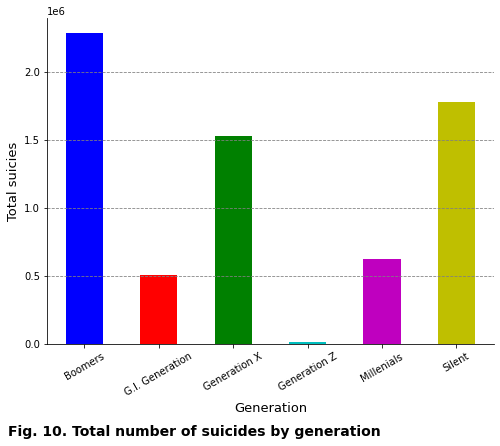

In [285]:
plt.rcParams["figure.figsize"] =  [8,6]
colors = ["b","r","g","c","m","y"]

gen_table_graph = gen_table.plot(x = "generation", y ="suicides_no",kind = "bar",color = colors)
plt.xlabel("Generation", size = 13)
plt.ylabel("Total suicies", size = 13)
plt.title("Fig. 10. Total number of suicides by generation", 
          x = 0.33, y = -0.3,
          size = 14, fontweight = "bold")
plt.xticks(rotation = 30)
gen_table_graph.spines["right"].set_visible(False)
gen_table_graph.spines["top"].set_visible(False)

gen_table_graph.yaxis.grid(linestyle = "dashed",color = "gray")
gen_table_graph.get_legend().remove()

# total suicides by generation and age 

In [286]:
generation_data = data.pivot_table(values =["suicides_per_100k_pop"],
                                   index = ["year","age","generation"],
                                   aggfunc=sum).reset_index()
generation_data

,year,age,generation,suicides_per_100k_pop
0,1985,15-24 years,Generation X,809.25
1,1985,25-34 years,Boomers,960.84
2,1985,35-54 years,Silent,1190.69
3,1985,5-14 years,Generation X,51.56
4,1985,55-74 years,G.I. Generation,1449.06
5,1985,75+ years,G.I. Generation,2350.49
6,1986,15-24 years,Generation X,782.60
7,1986,25-34 years,Boomers,1017.01
8,1986,35-54 years,Silent,1122.76
...,...,...,...,...


In [287]:
# in the below , we will sort data according to age and we'll see the spread of suicide cases across generations.

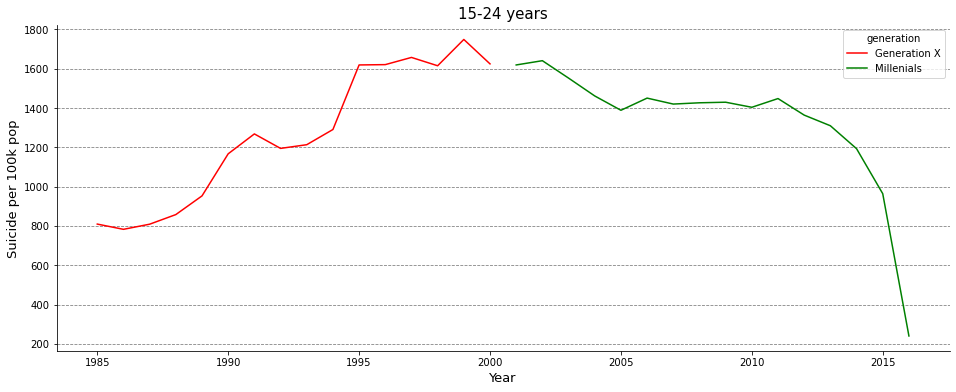

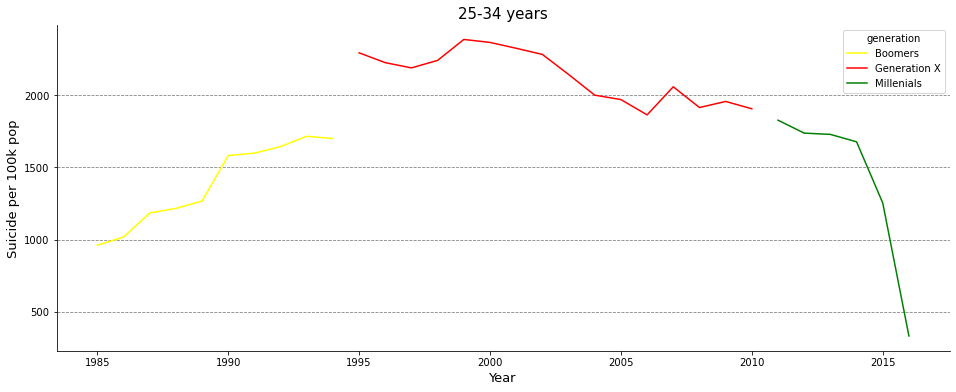

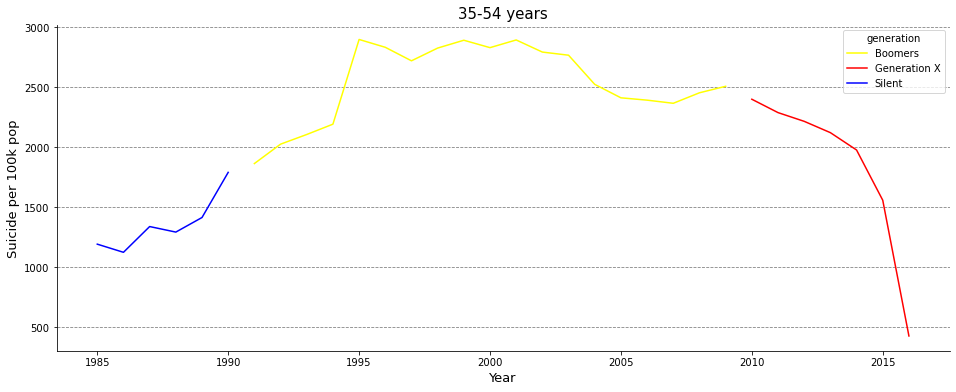

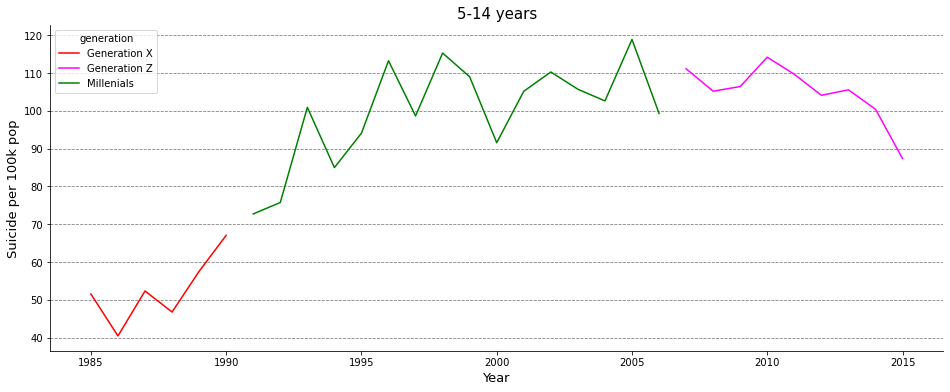

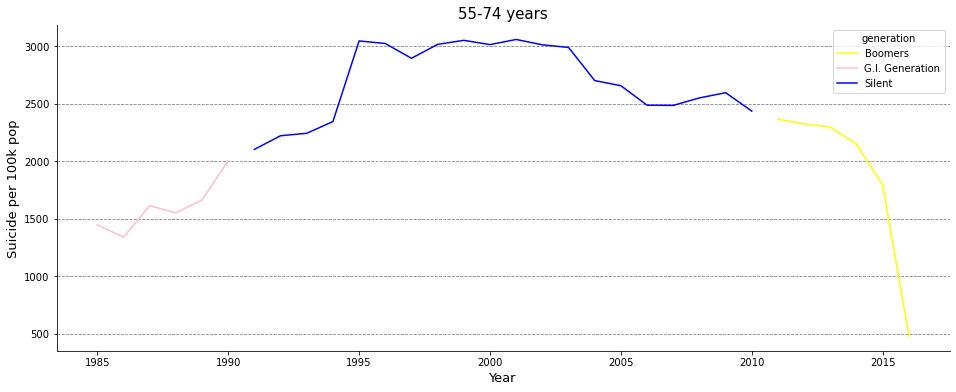

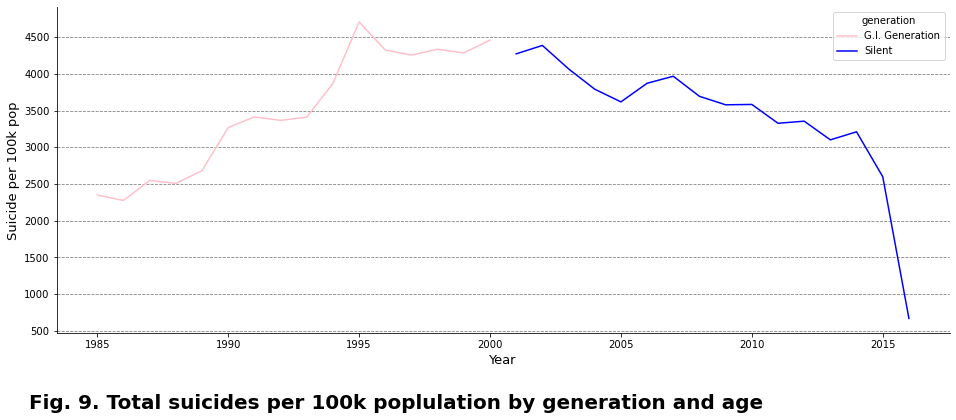

In [288]:
plt.rcParams["figure.figsize"] = [16,6]
first = generation_data[generation_data.age == "15-24 years"]
first1 = first.pivot_table(index = "year", columns="generation",values = "suicides_per_100k_pop")

second = generation_data[generation_data.age == "25-34 years"]
second2 = second.pivot_table(index = "year", columns="generation",values = "suicides_per_100k_pop")

third = generation_data[generation_data.age == "35-54 years"]
third3 = third.pivot_table(index = "year", columns="generation",values = "suicides_per_100k_pop")

fourth = generation_data[generation_data.age == "5-14 years"]
fourth4 = fourth.pivot_table(index = "year", columns="generation",values = "suicides_per_100k_pop")

fifth = generation_data[generation_data.age == "55-74 years"]
fifth5 = fifth.pivot_table(index = "year", columns="generation",values = "suicides_per_100k_pop")

sixth = generation_data[generation_data.age == "75+ years"]
sixth6 = sixth.pivot_table(index = "year", columns="generation",values = "suicides_per_100k_pop")

a = first1.plot(color = ["red","green"])
b = second2.plot(color = ["yellow","red","green"])
c = third3.plot(color = ["yellow","red","blue"])
d = fourth4.plot(color = ["red","magenta","green"])
e=  fifth5.plot(color = ["yellow","pink","blue"])
f = sixth6.plot(color = ["pink","blue"])

gen_list  = [a,b,c,d,e,f]

for graph in gen_list:
    
    
    graph.set_xlabel("Year",size = 13)
    graph.set_ylabel("Suicide per 100k pop", size = 13)
    
    graph.spines["right"].set_visible(False)
    graph.spines["top"].set_visible(False)
    
    graph.set_axisbelow(True)
    graph.yaxis.grid(linestyle = "dashed",color = "gray")
    
    if graph == a:
        graph.set_title('15-24 years', size = 15)
    if graph == b:
        graph.set_title('25-34 years', size = 15)
    if graph == c:
        graph.set_title('35-54 years', size = 15)
    if graph == d:
        graph.set_title('5-14 years', size = 15)
    if graph == e:
        graph.set_title('55-74 years', size = 15)
    if graph == f:
        graph.set_title('75+ years', size = 15)

f.set_title("Fig. 9. Total suicides per 100k poplulation by generation and age"
                               , x = 0.38, y = -0.25, 
                               size = 20, fontweight = "bold")
plt.show()
        


# Population and Suicide by Risk

Text(0.38, -0.25, 'Fig. 10. Visualization of the target variable')

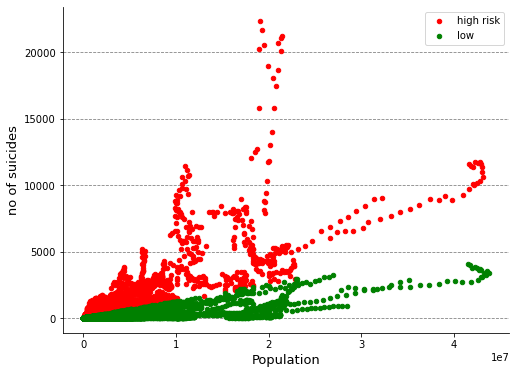

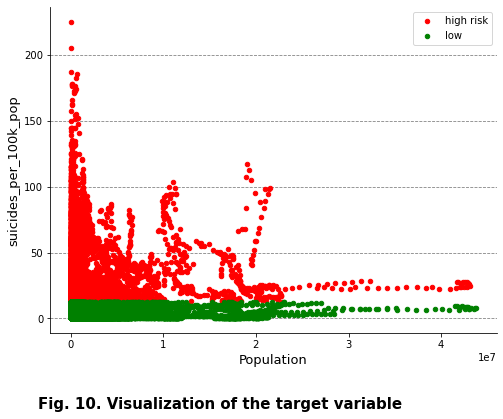

In [289]:
plt.rcParams["figure.figsize"] = [8,6]

high_risk = data[data.risk ==1]
low_risk = data[data.risk==0]

#suicide_no

high_plot = high_risk.plot(kind = "scatter", x = "population" , y = "suicides_no",color = "red", label = "high risk")
low_plot =  low_risk.plot(kind = "scatter", x = "population" , y = "suicides_no",color = "green", label = "low" ,ax= high_plot)

high_plot.set_xlabel("Population", size = 13)
high_plot.set_ylabel("no of suicides", size = 13)

#suicide rate

high_plot1 = high_risk.plot(kind = "scatter", x = "population" , y = "suicides_per_100k_pop",color = "red", label = "high risk")
low_plot1 =  low_risk.plot(kind = "scatter", x = "population" , y = "suicides_per_100k_pop",color = "green", label = "low" ,ax=high_plot1)

high_plot1.set_xlabel("Population", size = 13)
high_plot1.set_ylabel("suicides_per_100k_pop", size = 13)

graph_list = [high_plot,high_plot1]

for graphs in graph_list:
    
    graphs.spines["right"].set_visible(False)
    graphs.spines["top"].set_visible(False)
    
    graphs.yaxis.grid(color = "gray", linestyle = "dashed")
    graphs.set_axisbelow(True)
    
high_plot1.set_title("Fig. 10. Visualization of the target variable"
                               , x = 0.38, y = -0.25, 
                               size = 15, fontweight = "bold")

# Number of Observations in Each Class

In [290]:
print("\033[1m No. of observations in each class: \033[0m")

count = data['risk'].value_counts()
count

 No. of observations in each class: 


0    19061
1     8759
Name: risk, dtype: int64

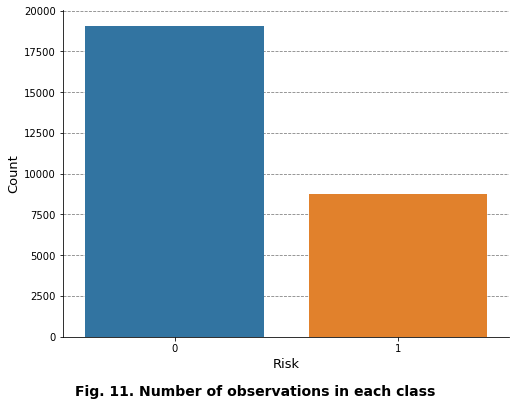

In [291]:
plt.rcParams["figure.figsize"] = [8,6]

count_plot = sns.countplot(data =data,x = "risk")
plt.xlabel("Risk", size = 13)
plt.ylabel("Count", size = 13)
plt.title("Fig. 11. Number of observations in each class", 
          x = 0.43, y = -0.2,
          size = 14, fontweight = "bold")

count_plot.spines["right"].set_visible(False)
count_plot.spines["top"].set_visible(False)

count_plot.set_axisbelow(True)
count_plot.yaxis.grid(color = "gray", linestyle = "dashed")

plt.show()

In [292]:
# we see that the classes are imbalanced. hence we have to upsample the minority class


In [293]:
#upscaling
#separating the majority and minority class

majority  = data[data.risk==0]
minority = data[data.risk==1]

upsampled = resample(minority,replace = True,n_samples = 19061,random_state = 123)

df=  pd.concat([majority,upsampled])

print("no. of observations in each class after upsampling")

count_up = df['risk'].value_counts()
count_up

no. of observations in each class after upsampling


1    19061
0    19061
Name: risk, dtype: int64

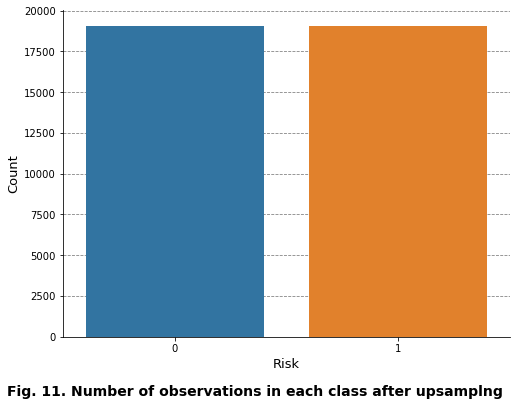

In [294]:
plt.rcParams["figure.figsize"] = [8,6]

count_plot_up = sns.countplot(x = "risk",data = df)

plt.xlabel("Risk", size = 13)
plt.ylabel("Count", size = 13)
plt.title("Fig. 11. Number of observations in each class after upsamplng", 
          x = 0.43, y = -0.2,
          size = 14, fontweight = "bold")

count_plot_up.spines["right"].set_visible(False)
count_plot_up.spines["top"].set_visible(False)

count_plot_up.set_axisbelow(True)
count_plot_up.yaxis.grid(color = "gray", linestyle = "dashed")

plt.show()

### Getting the  data ready for classification

In [295]:
df.head(10)

,country,year,sex,age,suicides_no,population,suicides_per_100k_pop,country-year,gdp_for_year,gdp_per_capita,generation,risk
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,2156624900.00,796,Generation X,0
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,2156624900.00,796,Silent,0
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,2156624900.00,796,Generation X,0
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,2156624900.00,796,G.I. Generation,0
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,2156624900.00,796,Boomers,0
5,Albania,1987,female,75+ years,1,35600,2.81,Albania1987,2156624900.00,796,G.I. Generation,0
6,Albania,1987,female,35-54 years,6,278800,2.15,Albania1987,2156624900.00,796,Silent,0
7,Albania,1987,female,25-34 years,4,257200,1.56,Albania1987,2156624900.00,796,Boomers,0
8,Albania,1987,male,55-74 years,1,137500,0.73,Albania1987,2156624900.00,796,G.I. Generation,0
9,Albania,1987,female,5-14 years,0,311000,0.00,Albania1987,2156624900.00,796,Generation X,0


In [296]:
#converting categorical values to numerical

label = LabelEncoder()

In [297]:
df["sex"] = label.fit_transform(df["sex"])
df["country"] = label.fit_transform(df["country"])

df.generation.replace(["G.I. Generation", "Silent", "Boomers", "Generation X", "Millenials", "Generation Z"],
                      ["0", "1", "2", "3", "4", "5"], inplace = True)

df["generation"] = df["generation"].astype(int)

df.age.replace(["5-14 years", "15-24 years", "25-34 years", 
                "35-54 years", "55-74 years", "75+ years"],
              [np.array([5,14]).mean(), np.array([15,24]).mean(), np.array([25,34]).mean(), 
               np.array([35,54]).mean(), np.array([55,74]).mean(), np.array([75]).mean()],
               inplace = True
              )

# Classification

In [319]:
df.head()

,country,year,sex,age,suicides_no,population,suicides_per_100k_pop,country-year,gdp_for_year,gdp_per_capita,generation,risk
0,0,1987,1,19.50,21,312900,6.71,Albania1987,2156624900.00,796,3,0
1,0,1987,1,44.50,16,308000,5.19,Albania1987,2156624900.00,796,1,0
2,0,1987,0,19.50,14,289700,4.83,Albania1987,2156624900.00,796,3,0
3,0,1987,1,75.00,1,21800,4.59,Albania1987,2156624900.00,796,0,0
4,0,1987,1,29.50,9,274300,3.28,Albania1987,2156624900.00,796,2,0


In [300]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [379]:
vif_data= pd.DataFrame()

In [380]:
df_temp = df.drop(columns = ["country-year"], axis = 1)
df_temp

,country,year,sex,age,suicides_no,population,suicides_per_100k_pop,gdp_for_year,gdp_per_capita,generation,risk
0,0,1987,1,19.50,21,312900,6.71,2156624900.00,796,3,0
1,0,1987,1,44.50,16,308000,5.19,2156624900.00,796,1,0
2,0,1987,0,19.50,14,289700,4.83,2156624900.00,796,3,0
3,0,1987,1,75.00,1,21800,4.59,2156624900.00,796,0,0
4,0,1987,1,29.50,9,274300,3.28,2156624900.00,796,2,0
5,0,1987,0,75.00,1,35600,2.81,2156624900.00,796,0,0
6,0,1987,0,44.50,6,278800,2.15,2156624900.00,796,1,0
7,0,1987,0,29.50,4,257200,1.56,2156624900.00,796,2,0
8,0,1987,1,64.50,1,137500,0.73,2156624900.00,796,0,0
...,...,...,...,...,...,...,...,...,...,...,...


In [381]:
vif_data["feature"]= df_temp.columns
vif_data

,feature
0,country
1,year
2,sex
3,age
4,suicides_no
5,population
6,suicides_per_100k_pop
7,gdp_for_year
8,gdp_per_capita
9,generation


In [382]:
vif_data["VIF"] = [variance_inflation_factor(df_temp.values,i) for i in range(len(vif_data))]
vif_data

,feature,VIF
0,country,1.03
1,year,0.00
2,sex,1.40
3,age,6.97
4,suicides_no,2.16
5,population,3.33
6,suicides_per_100k_pop,2.09
7,gdp_for_year,2.64
8,gdp_per_capita,1.24
9,generation,6.90


In [383]:
#we drop country-year(we already have country and year as sep variables), 
#risk(coz that's the target variable) & suicides_per_100k_pop from X
#The reason to drop suicide_per_100k_pop is because this variable shares a linear relationship between popn and suicides_no
#(popn/100k)*suicides_per_100K-pop = suicides_no
#if suicides_per_100K-pop is included, then our model will suffer from multi-collinearity problem
#we see that generation amd age have a high VIF, hence we drop the generation variable too 

X_ = df.drop(["risk","country-year","suicides_per_100k_pop","generation"],axis = 1)
y= df["risk"]


In [384]:
X_.head()

,country,year,sex,age,suicides_no,population,gdp_for_year,gdp_per_capita
0,0,1987,1,19.50,21,312900,2156624900.00,796
1,0,1987,1,44.50,16,308000,2156624900.00,796
2,0,1987,0,19.50,14,289700,2156624900.00,796
3,0,1987,1,75.00,1,21800,2156624900.00,796
4,0,1987,1,29.50,9,274300,2156624900.00,796


In [385]:
scaler = StandardScaler()

In [386]:
scaled_X = (X_-X_.mean())/ X_.std()

In [387]:
X_train,X_test,y_train,y_test = train_test_split(scaled_X,y, test_size =0.25 ,random_state = 40)

In [388]:
X_test

,country,year,sex,age,suicides_no,population,gdp_for_year,gdp_per_capita
19336,0.66,1.52,0.84,-1.04,0.17,0.13,0.04,-0.12
24732,1.38,-0.73,-1.19,1.36,-0.25,-0.39,-0.09,1.81
15931,0.21,-0.73,0.84,0.04,-0.30,-0.46,-0.32,-0.39
20815,0.83,0.57,-1.19,-1.04,-0.27,-0.07,-0.24,-0.60
7367,-0.85,1.28,-1.19,0.04,-0.22,-0.10,-0.18,0.18
5429,-1.05,-0.37,-1.19,0.91,-0.29,-0.24,-0.26,-0.60
23763,1.24,0.34,-1.19,0.04,-0.06,1.07,0.39,0.47
22143,1.04,1.28,-1.19,0.04,-0.24,-0.22,-0.29,-0.60
22046,1.04,0.34,0.84,-1.04,-0.25,-0.34,-0.30,-0.73
...,...,...,...,...,...,...,...,...


# Logistic Regression

In [389]:
from sklearn.linear_model import LogisticRegression

In [390]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train,y_train)


LogisticRegression()

In [391]:
lr_pred = logistic_model.predict(X_test)
lr_pred

array([1, 1, 1, ..., 0, 0, 0])

In [392]:
lr_train_acc = logistic_model.score(X_train,y_train)
lr_test_acc = logistic_model.score(X_test,y_test)

print("\033[1m Logisitic regression accuracies :\033[0m")
print(" Training Accuracy: %.2f%%" % (lr_train_acc*100.0))
print("Test Accuracy: %0.3f%%" % (lr_test_acc*100))
print("")

lm_confusion = metrics.confusion_matrix(y_test,lr_pred)
print("\033[1m Confusion matrix :\033[0m")
print(lm_confusion)
print("")

lr_report = metrics.classification_report(y_test,lr_pred)
print("\033[1m Logistic Regression Classification :\033[0m")
print(lr_report)

 Logisitic regression accuracies :
 Training Accuracy: 91.26%
Test Accuracy: 91.753%

 Confusion matrix :
[[4376  369]
 [ 417 4369]]

 Logistic Regression Classification :
              precision    recall  f1-score   support

           0       0.91      0.92      0.92      4745
           1       0.92      0.91      0.92      4786

    accuracy                           0.92      9531
   macro avg       0.92      0.92      0.92      9531
weighted avg       0.92      0.92      0.92      9531



# Neural network classifier(MLP)

In [393]:
nn_model = MLPClassifier(solver='lbfgs',random_state=40,max_iter=300)
nn_model.fit(X_train,y_train)

nn_pred = nn_model.predict(X_test)

nn_train_acc = nn_model.score(X_train,y_train)
nn_test_acc = nn_model.score(X_test,y_test)

print("\033[1m neural networok accuracies :\033[0m")

print(" Training Accuracy : %0.2f%%" %(nn_train_acc*100))
print(" Testing Accuracy : %0.2f%%" %(nn_test_acc*100))
print("")



nn_confusion = metrics.confusion_matrix(y_test,nn_pred)
print("\033[1m neural network Confusion matrix : \033[0m")
nn_confusion
print(" ")

nn_classification = metrics.classification_report(y_test,nn_pred)
print("\033[1m neural network classification report: \033[0m")
print(nn_classification)


 neural networok accuracies :
 Training Accuracy : 99.31%
 Testing Accuracy : 98.77%

 neural network Confusion matrix : 
 
 neural network classification report: 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4745
           1       0.99      0.99      0.99      4786

    accuracy                           0.99      9531
   macro avg       0.99      0.99      0.99      9531
weighted avg       0.99      0.99      0.99      9531



# Decision Trees

In [395]:
dt_model = DecisionTreeClassifier(max_depth=30, max_leaf_nodes=40)
dt_model.fit(X_train,y_train)

dt_pred = dt_model.predict(X_test)

dt_train_acc = dt_model.score(X_train,y_train)
dt_test_acc = dt_model.score(X_test,y_test)

print("\033[1m decision tree accuracies :\033[0m")

print(" Training Accuracy : %0.2f%%" %(dt_train_acc*100))
print(" Testing Accuracy : %0.2f%%" %(dt_test_acc*100))
print("")



dt_confusion = metrics.confusion_matrix(y_test,dt_pred)
print("\033[1m decision tree Confusion matrix : \033[0m")
dt_confusion
print(" ")

dt_classification = metrics.classification_report(y_test,dt_pred)
print("\033[1m decision tree classification report: \033[0m")
print(dt_classification)

 decision tree accuracies :
 Training Accuracy : 94.87%
 Testing Accuracy : 94.01%

 decision tree Confusion matrix : 
 
 decision tree classification report: 
              precision    recall  f1-score   support

           0       0.96      0.91      0.94      4745
           1       0.92      0.97      0.94      4786

    accuracy                           0.94      9531
   macro avg       0.94      0.94      0.94      9531
weighted avg       0.94      0.94      0.94      9531



# Random Forest

In [422]:
rf_model = RandomForestClassifier(n_estimators=100, min_samples_leaf=5, random_state = 40)
rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)

rf_train_acc = rf_model.score(X_train, y_train)
rf_test_acc = rf_model.score(X_test, y_test)

print(" Training Accuracy : %0.2f%%" %(rf_train_acc*100))
print(" Testing Accuracy : %0.2f%%" %(rf_test_acc*100))
print("")

rf_con_mat = metrics.confusion_matrix(y_test, rf_pred)
print("\033[1m Confusion matrix for random forest: \033[0m")
print(rf_con_mat)
print("")

rf_report = metrics.classification_report(y_test, rf_pred)
print("\033[1m Random forest report: \033[0m")
print(rf_report)

 Training Accuracy : 99.51%
 Testing Accuracy : 98.41%

 Confusion matrix for random forest: 
[[4621  124]
 [  28 4758]]

 Random forest report: 
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      4745
           1       0.97      0.99      0.98      4786

    accuracy                           0.98      9531
   macro avg       0.98      0.98      0.98      9531
weighted avg       0.98      0.98      0.98      9531



In [423]:
rf_model

RandomForestClassifier(min_samples_leaf=5, random_state=40)

## XGBoost

In [405]:
xgb = XGBClassifier()

In [406]:
xg_model = xgb.fit(X_train,y_train)
xg_pred = xg_model.predict(X_test)

In [407]:
xg_train_acc = xg_model.score(X_train,y_train)
xg_test_acc = xg_model.score(X_test,y_test)

In [414]:
print(f"Training Accuracy : {xg_train_acc*100:,.2f}%")
print(f"Testing Accuracy :{xg_test_acc*100:,.2f}%")

Training Accuracy : 97.78%
Testing Accuracy :97.09%


In [416]:
xg_con_mat = metrics.confusion_matrix(y_test, xg_pred)
print("\033[1m Confusion matrix for random forest: \033[0m")
print(xg_con_mat)
print("")

xg_report = metrics.classification_report(y_test, xg_pred)
print("\033[1m Random forest report: \033[0m")
print(xg_report)

 Confusion matrix for random forest: 
[[4513  232]
 [  45 4741]]

 Random forest report: 
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      4745
           1       0.95      0.99      0.97      4786

    accuracy                           0.97      9531
   macro avg       0.97      0.97      0.97      9531
weighted avg       0.97      0.97      0.97      9531



## hyper parameter tuning of Random Forest

In [445]:
rndm = RandomForestClassifier(n_estimators=10)



In [446]:
parameters = {'n_estimators':[1,2,3,4,5,6,7,8,9,10],
              'criterion':["gini","entropy"],
              'max_depth':[2,6,8,10,12,14,16,17,18,19,20],
              'min_samples_split': [0.5,1,2,3,5,6],
              'min_samples_leaf' : [1,5,8,10,12,15]
             }

In [447]:
clf_rndm = GridSearchCV(rndm,parameters,n_jobs=-1,cv=3)
clf_rndm.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(n_estimators=10), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 6, 8, 10, 12, 14, 16, 17, 18, 19, 20],
                         'min_samples_leaf': [1, 5, 8, 10, 12, 15],
                         'min_samples_split': [0.5, 1, 2, 3, 5, 6],
                         'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]})

In [449]:
print("The best parameters for Random_Classifier are :\n", clf_rndm.best_params_)

The best parameters for Random_Classifier are :
 {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}


## Random Forest after tuned

In [450]:
rndm_model_tuned = RandomForestClassifier(n_estimators=100,max_depth=20,criterion='entropy',min_samples_split=2,min_samples_leaf=1)
rndm_model_tuned.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', max_depth=20)

In [451]:
rndm_tuned_predict = rndm_model_tuned.predict(X_test)

In [453]:
rndm_tuned_train = rndm_model_tuned.score(X_train,y_train)
rndm_tuned_test =rndm_model_tuned.score(X_test,y_test)

print("\033[1m Accuracy Score : \033[0m")
print("Train accuracy : %.2f%% " % (rndm_tuned_train*100))
print("Test accuracy : %.2f%% " % (rndm_tuned_test*100))
print("")

rndm_tuned_conf = metrics.confusion_matrix(y_test,rndm_tuned_predict)
print("\033[1m Confusion Matrix : \033[0m")
print(rndm_tuned_conf)
print("")

rndm_tuned_class = metrics.classification_report(y_test,rndm_tuned_predict)
print("\033[1m Classification Report :\033[0m")
print(rndm_tuned_class)


 Accuracy Score : 
Train accuracy : 100.00% 
Test accuracy : 98.74% 

 Confusion Matrix : 
[[4656   89]
 [  31 4755]]

 Classification Report :
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4745
           1       0.98      0.99      0.99      4786

    accuracy                           0.99      9531
   macro avg       0.99      0.99      0.99      9531
weighted avg       0.99      0.99      0.99      9531



# hyper parameter tuning of MLP classifier

In [397]:
mlp = MLPClassifier(max_iter=100)

parameters = {'hidden_layer_sizes' :[(50,50,50),(50,50,100),(50,)],'activation':['tanh','relu'],'solver':['adam','lbfgs'],
             'alpha':[0.001,0.05],'learning_rate':['constant','adaptive']}

clf = GridSearchCV(mlp,parameters,n_jobs=-1,cv=3)
clf.fit(X_train,y_train)

print('The best parameters are :\n' , clf.best_params_)

The best parameters are :
 {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'lbfgs'}


# MLP classifier after tuned

In [454]:
nn_model_tuned = MLPClassifier(activation = 'tanh',alpha=0.05,hidden_layer_sizes = (50,50,50),learning_rate='constant',
                               solver='lbfgs',max_iter=3000,random_state=40)

nn_model_tuned.fit(X_train,y_train)

nn_pred2 = nn_model_tuned.predict(X_test)

nn_tuned_acc_train = nn_model_tuned.score(X_train,y_train)
nn_tuned_acc_test = nn_model_tuned.score(X_test,y_test)

print("\033[1m Accuracy Score : \033[0m")
print("Train accuracy : %.2f%% " % (nn_tuned_acc_train*100))
print("Test accuracy : %.2f%% " % (nn_tuned_acc_test*100))
print("")

nn_tuned_conf = metrics.confusion_matrix(y_test,nn_pred2)
print("\033[1m Confusion Matrix : \033[0m")
print(nn_tuned_conf)
print("")

nn_tuned_class = metrics.classification_report(y_test,nn_pred2)
print("\033[1m Classification Report :\033[0m")
print(nn_tuned_class)



 Accuracy Score : 
Train accuracy : 100.00% 
Test accuracy : 99.82% 

 Confusion Matrix : 
[[4730   15]
 [   2 4784]]

 Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4745
           1       1.00      1.00      1.00      4786

    accuracy                           1.00      9531
   macro avg       1.00      1.00      1.00      9531
weighted avg       1.00      1.00      1.00      9531



### Even though both the MLP and the Random forest classifier after being tuned has a 100% accuracy in the training set, the  accuracy of Random Forest  is low in the test set compared to that of MLP classifier. 

### Hence, we conclude that MLP classifier is the best classifier for classifying and predicting groups at high risk of suicide.

In [157]:
probs_predict = nn_model_tuned.predict_proba(X_test)
probs_predict1 = probs_predict[:,1]
probs_predict1.shape

(9531,)

In [158]:
false,true,_ = metrics.roc_curve(y_test,probs_predict1)

Text(0.5, 1.0, 'ROC curve for neural model tuned')

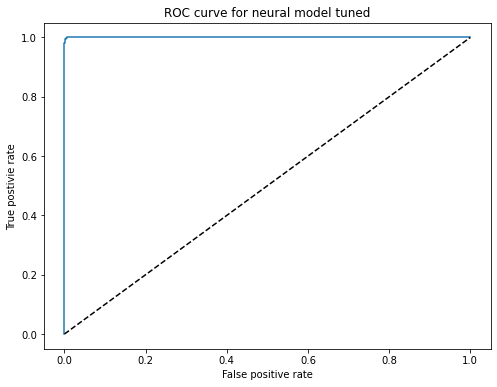

In [159]:
plt.rcParams["figure.figsize"] = [8,6]

plt.plot(false,true)
plt.plot([0,1],[0,1],"k--") # it draws a 45 degree line


plt.xlabel("False positive rate")
plt.ylabel("True postivie rate")
plt.title("ROC curve for neural model tuned")

### AUC score

In [160]:
predict1_ = nn_model_tuned.predict_proba(X_test)[:,1]
auc_nn = metrics.roc_auc_score(y_test,predict1_)

print("\033[1m the AUC score is :\033[0m  %0.6f%% " % (auc_nn*100))


 the AUC score is :  99.997103% 
